# Task 1: Time Series Analysis

## Description: Analyze and model time-series data to forecast future values (e.g., stock prices, sales).

- Plot and decompose the time series into trend, seasonality, and residual components.
- Implement moving average and exponential smoothing techniques.
- Build an ARIMA or SARIMA model for forecasting.
- Evaluate the model using metrics such as RMSE and visualize the forecast.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("data/all_SBUX_stocks_5yr.csv", parse_dates=['date'])
df.head()

,Unnamed: 0,date,open,high,low,close,volume,Name
0,498152,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,498153,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,498154,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,498155,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,498156,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


# Decomposition

In [3]:
df.set_index('date', inplace=True)

In [4]:
# Handle missing business days (weekends/holidays)
df = df.resample('B').ffill() 
series = df['close']

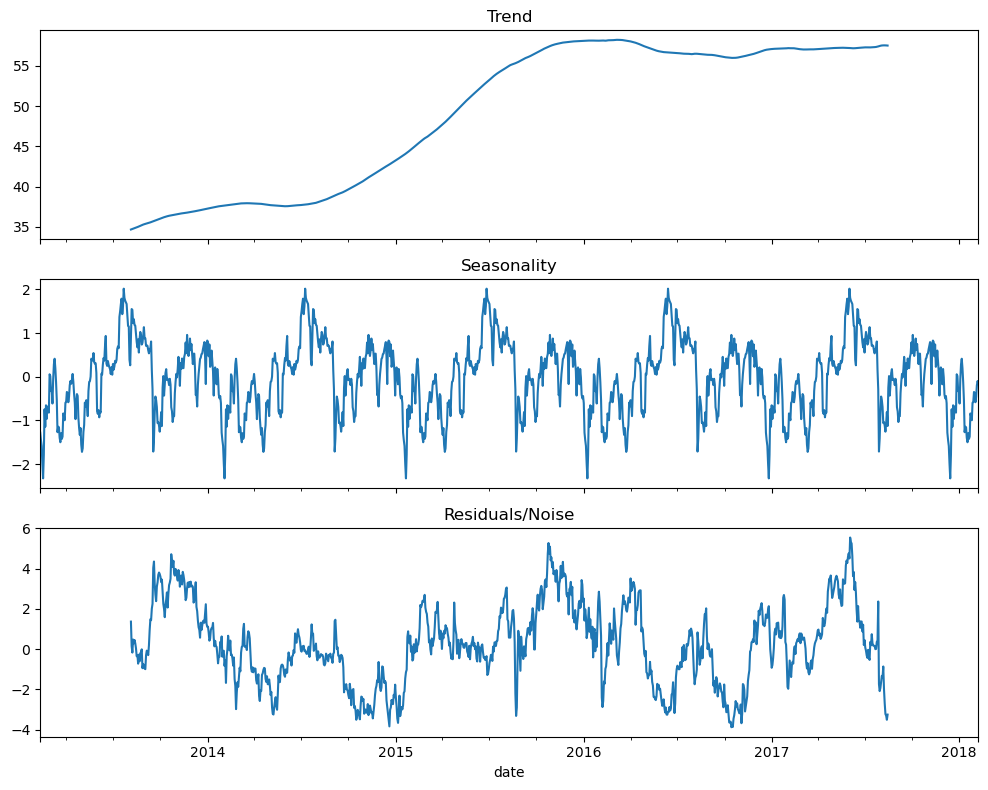

In [5]:
# Period is 252 (average trading days in a year)
decomposition = seasonal_decompose(series, model='additive', period=252)

fig, (ax1,ax2,ax3), = plt.subplots(3,1, figsize=(10,8), sharex=True)
decomposition.trend.plot(ax=ax1, title="Trend")
decomposition.seasonal.plot(ax=ax2, title="Seasonality")
decomposition.resid.plot(ax=ax3, title="Residuals/Noise")
plt.tight_layout()
plt.savefig("output/trend_Seasonality_and_resedual_plot.png")
plt.show()

# Smoothing Techniques

In [6]:
# Moving Average
df['MA30'] = series.rolling(window=30).mean()

In [7]:
# Exponential Smoothing (Alpha determines how much we weigh recent data)
model_ses = SimpleExpSmoothing(series).fit(smoothing_level=0.1, optimized=False)
df['SES'] = model_ses.fittedvalues

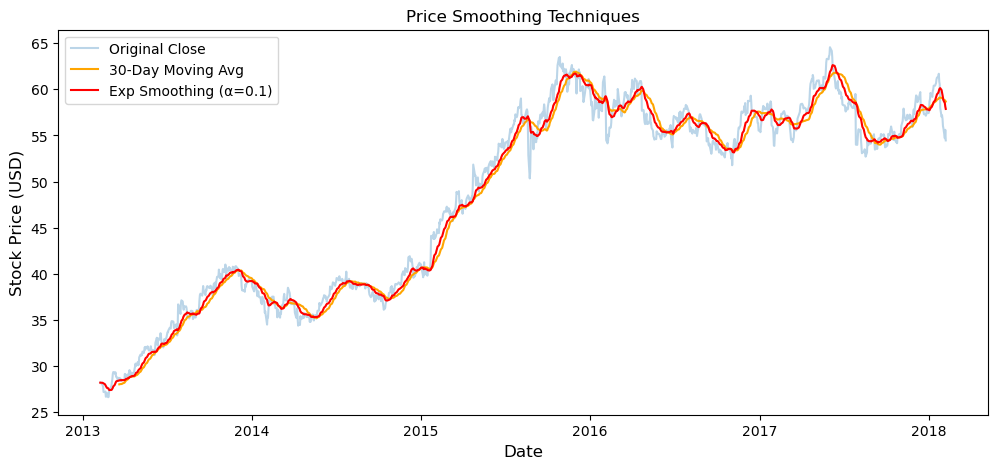

In [8]:
# Plotting the comparison
plt.figure(figsize=(12,5))
plt.plot(series, label='Original Close', alpha=0.3)
plt.plot(df['MA30'], label='30-Day Moving Avg', color='orange')
plt.plot(df['SES'], label='Exp Smoothing (α=0.1)', color='red')
plt.legend()
plt.title("Price Smoothing Techniques")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.savefig("output/price_smoothing_technique_plot.png")
plt.show()

# SARIMA Forecasting

In [9]:
# Train/Test Split (Last 30 days for testing)
train = series.iloc[:-30]
test = series.iloc[-30:]

In [10]:
# Build SARIMA Model
# Note: s=5 represents a trading week seasonality
model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 5))
results = model_sarima.fit(disp=False)

In [11]:
# Forecast 30 days out
forecast_obj = results.get_forecast(steps=30)
forecast_mean = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

In [12]:
# Combine predicted values and confidence intervals into one table
forecast_summary = pd.concat([forecast_mean, conf_int], axis=1)
forecast_summary.columns = ['Predicted_Close', 'Lower_Bound', 'Upper_Bound']

# Print the full 30-day forecast
print("-------- 30-Day Stock Price Forecast --------")
print(forecast_summary.head())

-------- 30-Day Stock Price Forecast --------
            Predicted_Close  Lower_Bound  Upper_Bound
2017-12-28        57.299148    56.117378    58.480918
2017-12-29        57.251080    55.568305    58.933855
2018-01-01        57.257482    55.194421    59.320544
2018-01-02        57.307576    54.923538    59.691614
2018-01-03        57.359607    54.693102    60.026112


# Evaluation and Visualization

In [13]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
print(f"SARIMA Model RMSE: ${rmse:.2f}")

SARIMA Model RMSE: $2.43


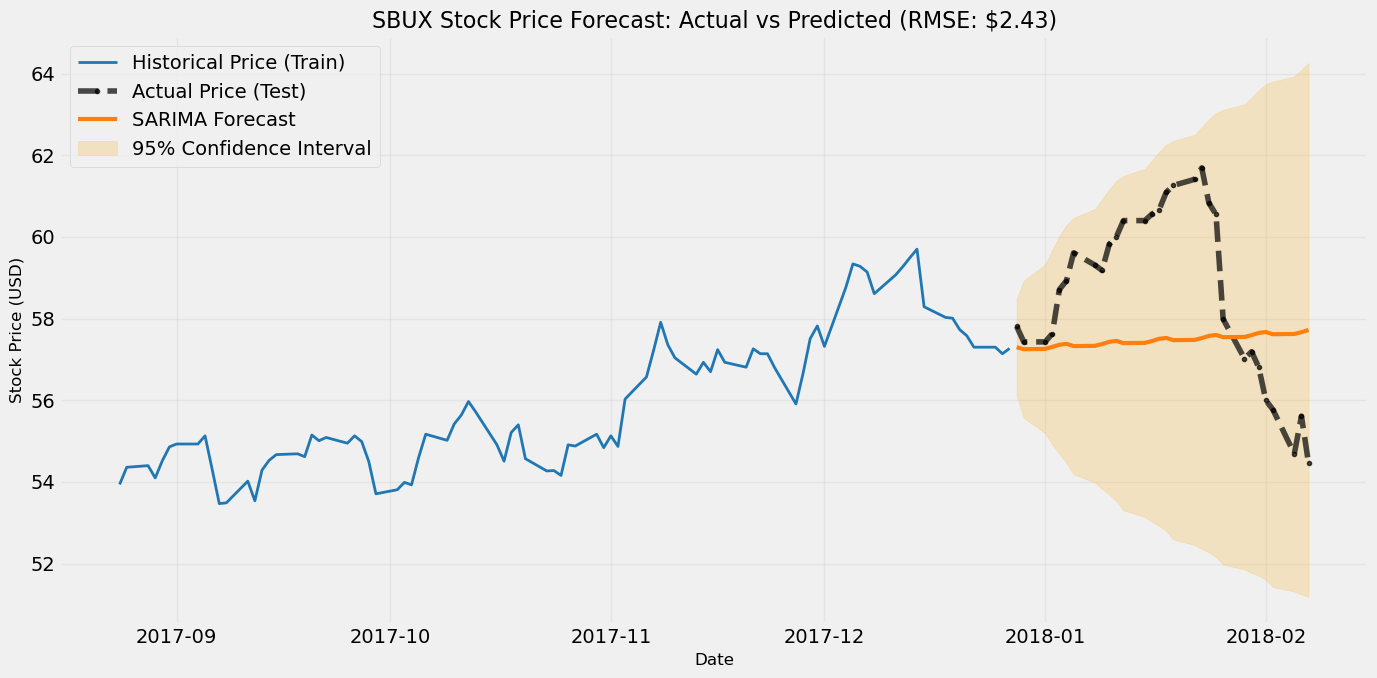

In [14]:
# Set the style for a professional look
plt.style.use('fivethirtyeight')
plt.figure(figsize=(14, 7))

# Plot the Training data (last 90 days for clarity, rather than the whole 5 years)
plt.plot(train.index[-90:], train[-90:], label='Historical Price (Train)', color='#1f77b4', linewidth=2)

# Plot the Actual Test data (the ground truth)
plt.plot(test.index, test, label='Actual Price (Test)', color='black', marker='o', markersize=3, linestyle='--', alpha=0.7)

# Plot the Forecasted Mean
plt.plot(forecast_mean.index, forecast_mean, label='SARIMA Forecast', color='#ff7f0e', linewidth=3)

# Plot the Confidence Interval (95%)
plt.fill_between(forecast_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.2, label='95% Confidence Interval')

# Formatting the Chart
plt.title(f'SBUX Stock Price Forecast: Actual vs Predicted (RMSE: ${rmse:.2f})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("output/stock_price_forecast.png")
plt.show()
